본 내용은 아래 링크를 참조하여 만들었습니다.
- EunHye Jung님의 github blog: https://eunhyejung.github.io/data_analysis/2018/07/24/data-processing-studying-with-python.html
- Kaggle: https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words 

In [28]:
import pandas as pd
import numpy as np

# 전처리
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

# multiprocessing
from multiprocessing import Pool

# 데이터 읽기
- NLP에서는 Text 데이터를 많이 사용하기때문에 csv형식으로 파일을 저장하기보다는 text 내의 쉼표와 섞이지 않기 위해서 구분다(delimiter)를 Tab으로 저장한다. 그래서 tcv 확장자를 많이 사용한다.
- 데이터를 불러올때 또한 read_csv를 사용하여 delimiter와 quoting이라는 paramter를 사용하는데 quoting은 0~3까지의 값을 갖는 인자이다.
- quoting=3 tells Python to ignore doubled quotes 이라고 하는데 이게 "를 무시하고 읽지 않는다라고 받아들였다. 그러나 ignore doubled quotes는 읽지않는 것이 아닌 duoble quotes를 무시하고 그 사이에 Tab이 있을 시 분리한다라고 보면된다. 바로 와닿지는 않지만 예시를 들자면

ex) "나는 \t NLP 공부 중이다." 
- delimiter="\t", quoting=3 의 경우 double quotes를 무시하고 ["나는" , "NLP 공부 중이다."] 처럼 두 값으로 나눌 수 있다.
- delimiter="\t", quoting이 3이 아닌 경우 duoble quotes를 무시하지 않고 ["나는 \t NLP 공부 중이다."] 로 하나의 값을 나타낸다.

In [2]:
# quoting = 3 은 
train = pd.read_csv('../dataset/labeledTrainData.tsv',delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('../dataset/unlabeledTrainData.tsv', delimiter='\t', quoting=3)
test = pd.read_csv('../dataset/testData.tsv',delimiter='\t')
print('train shape: ',train.shape)
print('unlabeled_train shape:',unlabeled_train.shape)
print('test shape: ',test.shape)

train shape:  (25000, 3)
unlabeled_train shape: (50000, 2)
test shape:  (25000, 2)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


# 전처리

아래 Text를 보면 html tag가 섞여있기 때문에 정제해야한다

In [4]:
train.loc[0,'review'][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

BeautifulSoup을 통해서 html tag가 섞여있는 Text를 parsing 한 후 get_text()를 통해서 text만 읽게되면 기존 text에 섞여있던 html tag를 모두 제외하고 text만 가져오게 된다.

In [5]:
example1 = BeautifulSoup(train.loc[0,'review'], 'html5lib')
print(train.loc[0,'review'][:700])
print(example1.get_text()[:700])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe 

html tag 이외에 특수문자를 정규표현식을 사용하여 제거한다.

In [6]:
letters_only = re.sub(pattern='[^a-zA-Z]', repl=' ',string=example1.get_text())
print(example1.get_text()[:700])
print(letters_only[:700])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw
 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe 

이제 대문자를 전부 소문자로 변환한 후 토큰화한다. **여기서 토큰화(tokenization)이란 단어를 분리하는 것을 말한다.**

In [7]:
lower_case = letters_only.lower()
# 문자를 공백을 기준으로 나눈다 => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

## 불용어 제거

stopwords.words()가 안될시 nltk.download('stopwords')를 통해서 설치한 후 다시 시도한다.

In [8]:
# nltk.download('stopwords')

In [9]:
stopwords.words('english'[:10])

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

stopwords에 있는 불용어를 제외하였더니 words가 437 -> 219개로 줄었다.

In [10]:
words = [ w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## 스테밍(stemming) (어간추출, 형태소분석)

어간 추출(stemming)은 형태론 및 정보 검색 분야에서 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어간의 어간을 분리해내는것을 의미한다. “message”, “messages”, “messaging”과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.

어간 추출에는 NLTK에서 제공하는 형태소 분석기를 사용하고, 포터(Porter) 형태소 분석기와 랭커스터(Lancaster)가 있음.

In [11]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is : {}".format(stemmer.stem("running")))
print("The stemmed form of running is : {}".format(stemmer.stem("runs")))
print("The stemmed form of running is : {}".format(stemmer.stem("run")))

The stemmed form of running is : run
The stemmed form of running is : run
The stemmed form of running is : run


In [12]:
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print("The stemmed form of running is : {}".format(stemmer.stem("running")))
print("The stemmed form of running is : {}".format(stemmer.stem("runs")))

The stemmed form of running is : run
The stemmed form of running is : run


In [13]:
from nltk.stem.snowball import SnowballStemmer

print('stemming 전 words[:10]: ',words[:10])

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
print('stemming 후 words[:10]: ',words[:10])

stemming 전 words[:10]:  ['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary']
stemming 후 words[:10]:  ['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']


## Lemmatization 음소표기법

다음 문장들을 살펴보자.  
1) *배*가 맛있다. 2) *배*를 타는 것이 재미있다.  
3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.  

위의 3개의 문장에서 “배”는 모두 다른 의미를 갖는다.
음소표기법은 이때, 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다.
영어에서 meet은 meeting으로 쓰였을때, 회의를 뜻하지만 meet일때는 만나다는 뜻을 가지는데, 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 추출하는것으로 보면 된다.

만일 아래와 같은 에러 메세지가 나온다면 nltk.download('wordnet')을 통해 wordnet을 설치해줍니다.
![](../images/error1.JPG)

In [14]:
# nltk.download('wordnet')

In [15]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

fly
fly


In [16]:
print('lemmatization 전 words[:10]: ',words[:10])
words = [ wordnet_lemmatizer.lemmatize(w) for w in words]
print('lemmatization 후 words[:10]: ',words[:10])

lemmatization 전 words[:10]:  ['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']
lemmatization 후 words[:10]:  ['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']


## 문자열 처리

위에서 정리한 내용을 바탕으로 문자열을 처리하는 함수를 만든다

In [17]:
import defs

In [18]:
clean_review = defs.review_to_words(train.loc[0,'review'])

print(train.loc[0,'review'])
print()
print(clean_review)

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

train data의 전체 review 개수는 25000개로 적지않은 수이다. 이런경우 전처리하는데 상당한 시간을 소요할 수 있다. 그렇기 때문에 멀티프로세싱 모듈을 사용해서 실행속도를 개선시키도록 한다.

- jupyter notebook에서 multiprocessing  사용시 주의할 점이 있으므로 아래 포스트를 참고한다.
https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
- **참고로 %%time를 사용한 cell 내의 변수는 저장되지 않는다**

In [19]:
num_reviews = train['review'].size
print('review 개수: ',num_reviews)

review 개수:  25000


In [45]:
%%time

clean_train_reviews = list()
for i in range(num_reviews):
    clean_train_reviews.append(defs.review_to_words(train.loc[i,'review']))

Wall time: 1min 1s


In [43]:
%%time

workers = 4
# 위에서 가져온 workers 수로 프로세스 풀을 정의
pool = Pool(processes=workers)
# 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
result = pool.map(defs._apply_df, [(d, defs.review_to_words) for d in np.array_split(train['review'], workers)])
pool.close()
# 작업 결과를 합쳐서 반환
clean_train_reviews = pd.concat(list(result))

Wall time: 18.8 s


In [39]:
%%time

workers = 8
# 위에서 가져온 workers 수로 프로세스 풀을 정의
pool = Pool(processes=workers)
# 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
result = pool.map(defs._apply_df, [(d, defs.review_to_words) for d in np.array_split(train['review'], workers)])
pool.close()
# 작업 결과를 합쳐서 반환
clean_train_reviews = pd.concat(list(result))

Wall time: 12.9 s


In [48]:
workers = 8
# 위에서 가져온 workers 수로 프로세스 풀을 정의
pool = Pool(processes=workers)
# 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
result = pool.map(defs._apply_df, [(d, defs.review_to_words) for d in np.array_split(train['review'], workers)])
pool.close()
# 작업 결과를 합쳐서 반환
clean_train_reviews = pd.concat(list(result))

In [66]:
workers = 8
# 위에서 가져온 workers 수로 프로세스 풀을 정의
pool = Pool(processes=workers)
# 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
result = pool.map(defs._apply_df, [(d, defs.review_to_words) for d in np.array_split(test['review'], workers)])
pool.close()
# 작업 결과를 합쳐서 반환
clean_test_reviews = pd.concat(list(result))

# 워드 클라우드

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [51]:
def displayWordCloud(data=None, backgroundcolor='white', width=800, height=600):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color=backgroundcolor,
                         width=width, height=height).generate(data)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

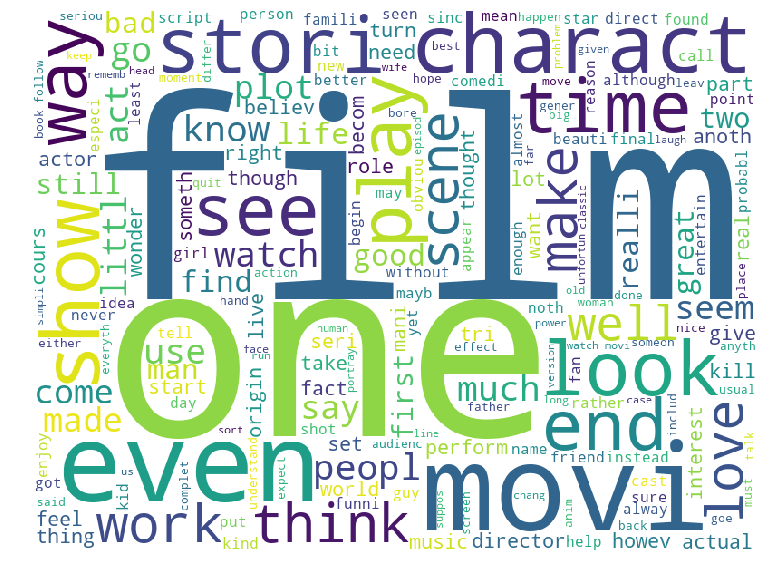

Wall time: 15.2 s


In [52]:
%%time

displayWordCloud(' '.join(clean_train_reviews))

# Creating Features from a Bag of Words (Using scikit-learn)

아래와 같이 두 가지 문장을 예로 들었을 때 a bag of words는 두 문장에 있는 단어들의 합집합이 된다. 각 문장별로 가방(a bag of words)에 있는 단어가 몇번 등장했는지 횟수를 센다

Sentence 1: "The cat sat on the hat"
Sentence 2: "The dog ate the cat and the hat"

From these two sentences, our vocabulary is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ the, cat, sat, on, hat, dog, ate, and }

Sentence 1: { 2, 1, 1, 1, 1, 0, 0, 0 }

Similarly, the features for Sentence 2 are: { 3, 1, 0, 0, 1, 1, 1, 1}

In [54]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None,
                             stop_words = None,   
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [62]:
train_data_features.shape

(25000, 5000)

In [64]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(len(vocab))
print(vocab)

5000
['abandon', 'abc', 'abil', 'abl', 'abomin', 'aborigin', 'abort', 'abound', 'abraham', 'abrupt', 'abruptli', 'absenc', 'absent', 'absolut', 'absorb', 'absurd', 'abund', 'abus', 'abysm', 'academi', 'accent', 'accept', 'access', 'accid', 'accident', 'acclaim', 'accompani', 'accomplish', 'accord', 'account', 'accur', 'accuraci', 'accus', 'ace', 'achiev', 'acid', 'acknowledg', 'acquaint', 'acquir', 'across', 'act', 'action', 'activ', 'actor', 'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'admir', 'admit', 'admittedli', 'adolesc', 'adopt', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'aesthet', 'affair', 'affect', 'affleck', 'afford', 'aforement', 'afraid', 'africa', 'african', 'afternoon', 'afterward', 'age', 'agenc', 'agenda', 'agent', 'aggress', 'ago', 'agre', 'ah', 'ahead', 'aid', 'aim', 'air', 'airplan', 'airport', 'aka', 'akin', 'akshay', 'al', 'ala', 'alan', 'alarm', 'albeit', 'albert', 'album', 'alco

In [65]:
import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

288 abandon
125 abc
562 abil
1259 abl
83 abomin
69 aborigin
92 abort
63 abound
93 abraham
76 abrupt
60 abruptli
118 absenc
83 absent
1845 absolut
154 absorb
403 absurd
66 abund
398 abus
110 abysm
298 academi
704 accent
781 accept
165 access
344 accid
246 accident
118 acclaim
197 accompani
271 accomplish
311 accord
297 account
349 accur
82 accuraci
204 accus
75 ace
578 achiev
102 acid
109 acknowledg
73 acquaint
97 acquir
971 across
8794 act
3694 action
268 activ
6876 actor
1588 actress
5065 actual
793 ad
409 adam
835 adapt
1147 add
261 addict
499 addit
183 address
148 adequ
440 admir
738 admit
134 admittedli
112 adolesc
162 adopt
226 ador
887 adult
275 advanc
172 advantag
773 adventur
228 advertis
262 advic
195 advis
78 aesthet
419 affair
428 affect
66 affleck
139 afford
126 aforement
343 afraid
212 africa
284 african
197 afternoon
183 afterward
1726 age
79 agenc
86 agenda
455 agent
103 aggress
1033 ago
779 agre
119 ah
396 ahead
289 aid
325 aim
842 air
106 airplan
96 airport
195 aka
67 

452 geniu
1367 genr
122 gentl
84 gentleman
511 genuin
933 georg
93 gerard
71 gere
614 german
227 germani
85 gestur
14141 get
62 ghetto
666 ghost
120 giallo
440 giant
249 gift
93 giggl
66 gilbert
64 gilliam
73 gillian
96 gimmick
73 gina
107 ginger
4064 girl
684 girlfriend
5792 give
1849 given
451 glad
104 glamor
85 glanc
66 glare
238 glass
123 glenn
214 glimps
114 global
77 globe
154 glori
71 glorifi
104 gloriou
143 glover
124 glow
9305 go
193 goal
1271 god
137 godfath
105 godzilla
2441 goe
100 goer
295 gold
123 goldberg
63 goldblum
259 golden
65 goldsworthi
754 gone
241 gonna
15360 good
72 goof
168 goofi
253 gordon
1055 gore
368 gorgeou
235 gori
3583 got
136 gothic
129 gotta
286 gotten
469 govern
270 grab
424 grace
488 grade
137 gradual
122 graduat
94 graham
74 graini
319 grand
101 grandfath
134 grandmoth
482 grant
442 graphic
128 grasp
60 grass
146 grate
244 gratuit
228 grave
127 gray
89 grayson
9171 great
174 greater
745 greatest
154 greatli
86 greed
91 greedi
122 greek
465 green
65 

1203 score
71 scorses
84 scotland
587 scott
93 scottish
130 scratch
690 scream
2799 screen
735 screenplay
230 screenwrit
182 screw
3342 script
80 scriptwrit
101 scroog
68 se
291 sea
165 seagal
82 seal
263 sean
517 search
1075 season
309 seat
2310 second
76 secondari
104 secondli
745 secret
147 secretari
93 secretli
248 section
260 secur
124 seduc
105 seduct
14111 see
126 seed
67 seedi
426 seek
7220 seem
347 seemingli
6681 seen
396 segment
81 seldom
199 select
1185 self
127 selfish
414 sell
127 seller
211 semi
65 senat
439 send
68 senior
2416 sens
94 sensat
103 senseless
149 sensibl
240 sensit
69 sensual
395 sent
192 sentenc
328 sentiment
79 sentinel
287 separ
93 septemb
1042 sequel
1609 sequenc
85 sergeant
3420 seri
450 serial
989 seriou
1042 serious
615 serv
136 servant
286 servic
85 session
4116 set
200 settl
74 setup
360 seven
129 seventi
1663 sever
1726 sex
453 sexi
1000 sexual
62 sg
103 sh
113 shade
318 shadow
194 shake
298 shakespear
83 shaki
133 shall
273 shallow
743 shame
81 sh

# Random Forest

In [67]:
print("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, train["sentiment"] )

Training the random forest...


In [68]:
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
print('Number of test reviews: ',num_reviews)

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "../submit/submission1.csv", index=False, quoting=3)

Number of test reviews:  25000


In [69]:
output.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1


# Public Leaderboard

submit | score
-------|-------
submission1.csv | 0.84456